# Recurrent Neural Networks

Here we will set up a simple example where we will try to predict if the stock market price for a company is going to be **high** (1.0), **medium** (0.5), or **low** (0.0) given the price over the previous two days.

First, let's set up a simple plot to view the stock of a company over time:

In [2]:

import matplotlib.pyplot as plt
from random import choice
from IPython.display import Image
import math

In [3]:
def stock_market_figure(observations, predicted_value=None, predictions=None, expected=None):
    plt.figure(figsize=(2*len(observations)+1,3))
    
    times = [i for i in range(0, len(observations))]
    
    # Plot a series of expectations
    if expected != None:        
        expected_time = [i for i in range(1, len(expected)+1)]
        plt.plot(
            expected_time,
            expected,
            linestyle="-",
            color="black",
            alpha=0.7,
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="#4ca32c",
            markeredgewidth=2,
            markersize=25,
            label="Expected"
        )
    
    # Plot a series of predicted values
    if predictions != None:
        prediction_time = [i for i in range(1, len(predictions)+1)]
        plt.plot(
            prediction_time,
            predictions,
            alpha=0.5,
            linestyle="--",
            color="black",
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="#adadad",
            markeredgewidth=2,
            markersize=25,
            label="Predicted"
        )
    
    if predicted_value != None:
        # Set the predicted value and time after the last observation
        prediction = [observations[-1], predicted_value]
        prediction_time = [len(observations)-1, len(observations)]
        
        # Plot the prediction
        plt.plot(
            prediction_time,
            prediction,
            linestyle="--",
            color="black",
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="lightgrey",
            markeredgewidth=2,
            markersize=25,
            label="Predicted"
        )
    
    # Plot the observations
    plt.plot(
        times, 
        observations,
        linestyle="-",
        color="black",
        marker="o",
        markeredgecolor="black",
        markerfacecolor="#4ca32c",
        markeredgewidth=1.5,
        markersize=25,
        label="Observed"
        )
    
    # Set the x labels based on the number of observations
    xlabels = []
    for i in range(0, len(observations) + 1):
        label = f"Day {i}"
        if i == len(observations):
            label = "Tomorrow"
        if i == len(observations)-1:
            label = "Today"
        if i == len(observations)-2:
            label = "Yesterday"
        elif i < len(observations)-2:
            label = f"{len(observations)-1-i} Days Ago"
        xlabels.append(label)
        
    
    plt.title("Stock Prices over Time", fontsize=16)
    plt.ylabel("Stock Price", fontsize=16)
    plt.xticks([i for i in range(0, len(observations) + 1)], labels=xlabels, fontsize=12)
    plt.yticks([0, 0.5, 1], labels=["Low\n0", "Medium\n0.5", "High\n1"], fontsize=12)
    plt.xlim((-0.5, len(observations) + 1))
    plt.ylim((-0.25, 1.25))
    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1.01, 1),  # slightly outside to the right
        borderaxespad=0,
        fontsize=12
    )
    
    # Set the spines of the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(width=2, length=6)
    
    plt.tight_layout()
    plt.show()

We can write the expected logic to check the predictions of our model. 

**Possible Scenarios:**
1. If the stock prices go up, we expect the stock prices to keep going up (to a maximum of "high")
2. If the stock prices go down, we expect the stock prices to keep going down (to a minimum of "low)
3. If the stock prices stay the same, we expect the stock prices to remain the same

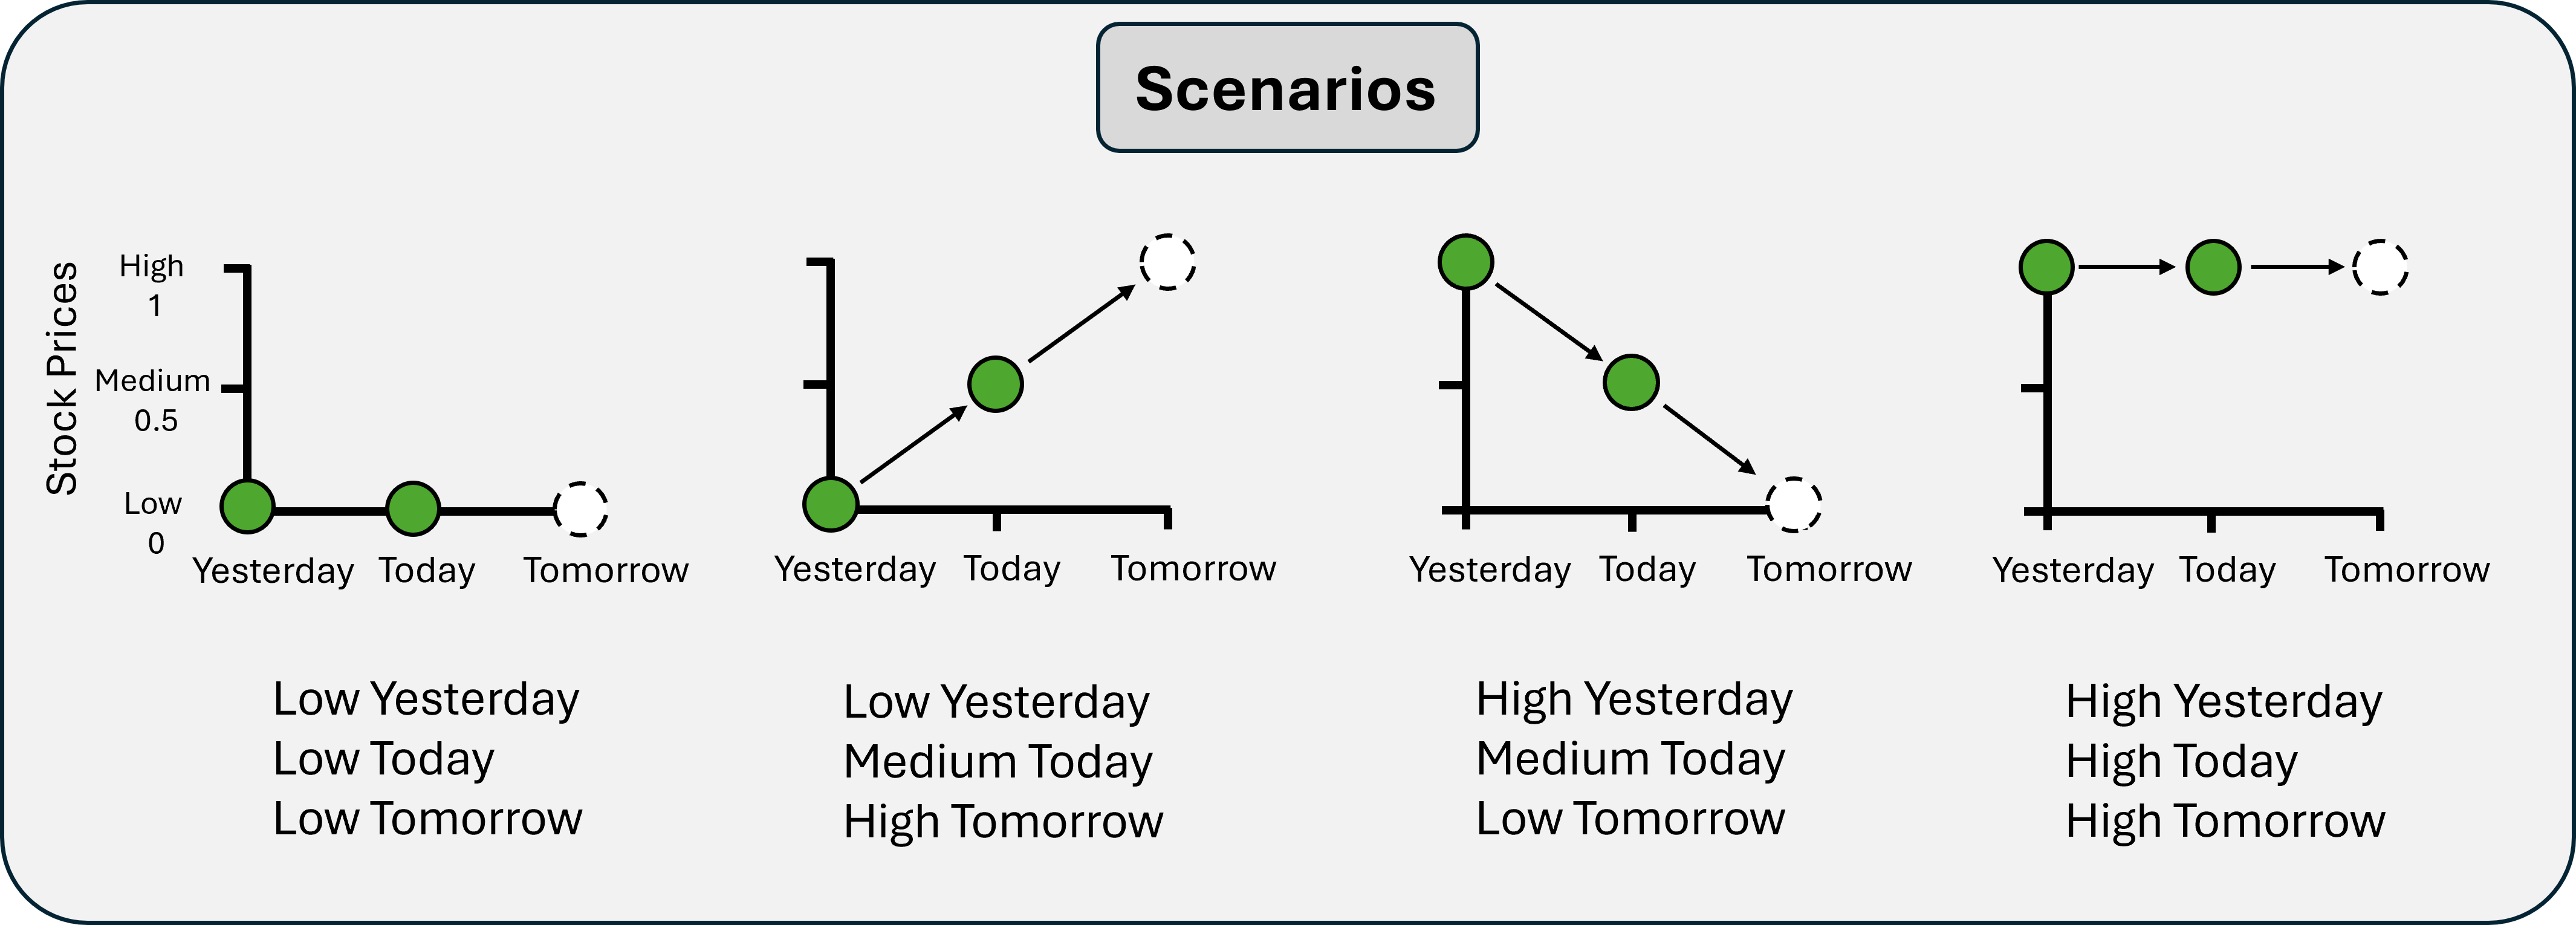

In [4]:
Image(filename='images/rnn_stock_scenarios.png', width=1000) 

In [5]:
def expected_logic(observations):
    # Stock prices stayed the same, predict stays the same
    if observations[-2] == observations[-1]:
        return float(observations[-1])
    
    # Stock prices went down, predict keeps going down
    if observations[-2] > observations[-1]:
        return max(0.0, observations[-1] - 0.5)
    
    # Stock prices went up, predict keeps going up
    if observations[-2] < observations[-1]:
        return min(1.0, observations[-1] + 0.5)

Once we have a function to check the expected logic, we can generate some random observations which fit the possibilities

In [6]:
def generate_random_observations(num_obs):
    first_choice = choice([0, 0.5, 1.0])
    rand_yesterday = first_choice
    
    rand_obs = [first_choice]
    for i in range(0, num_obs-1):
        if rand_yesterday == 0.0:
            rand_today = choice([0, 0.5])
        if rand_yesterday == 0.5:
            rand_today = choice([0, 0.5, 1.0])
        if rand_yesterday == 1.0:
            rand_today = choice([0.5, 1.0])
        rand_obs.append(float(rand_today))
        
        rand_yesterday = rand_today
    return rand_obs

We can run the following cell several times to check that the `generate_random_observations()` and `expected_logic` functions fit with our expectations.

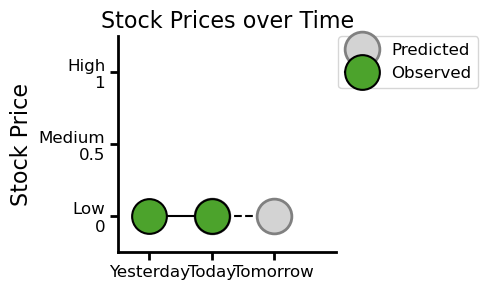

In [7]:
rand_obs = generate_random_observations(2)
prediction = expected_logic(rand_obs)
stock_market_figure(rand_obs, prediction)

## Creating a Recurrent Neural Network (RNN)
Now that we have a way to create observations, verify predictions, and visualize the results, let's start building a **Recurrent Neural Network** to make these predictions.

An RNN is made up of a bunch of repeating units that predict the value of a single time point called **recurrent units**. These recurrent units all have the same architecture, with **shared weights and biases**.

Here is what one of these units looks like for the current problem:

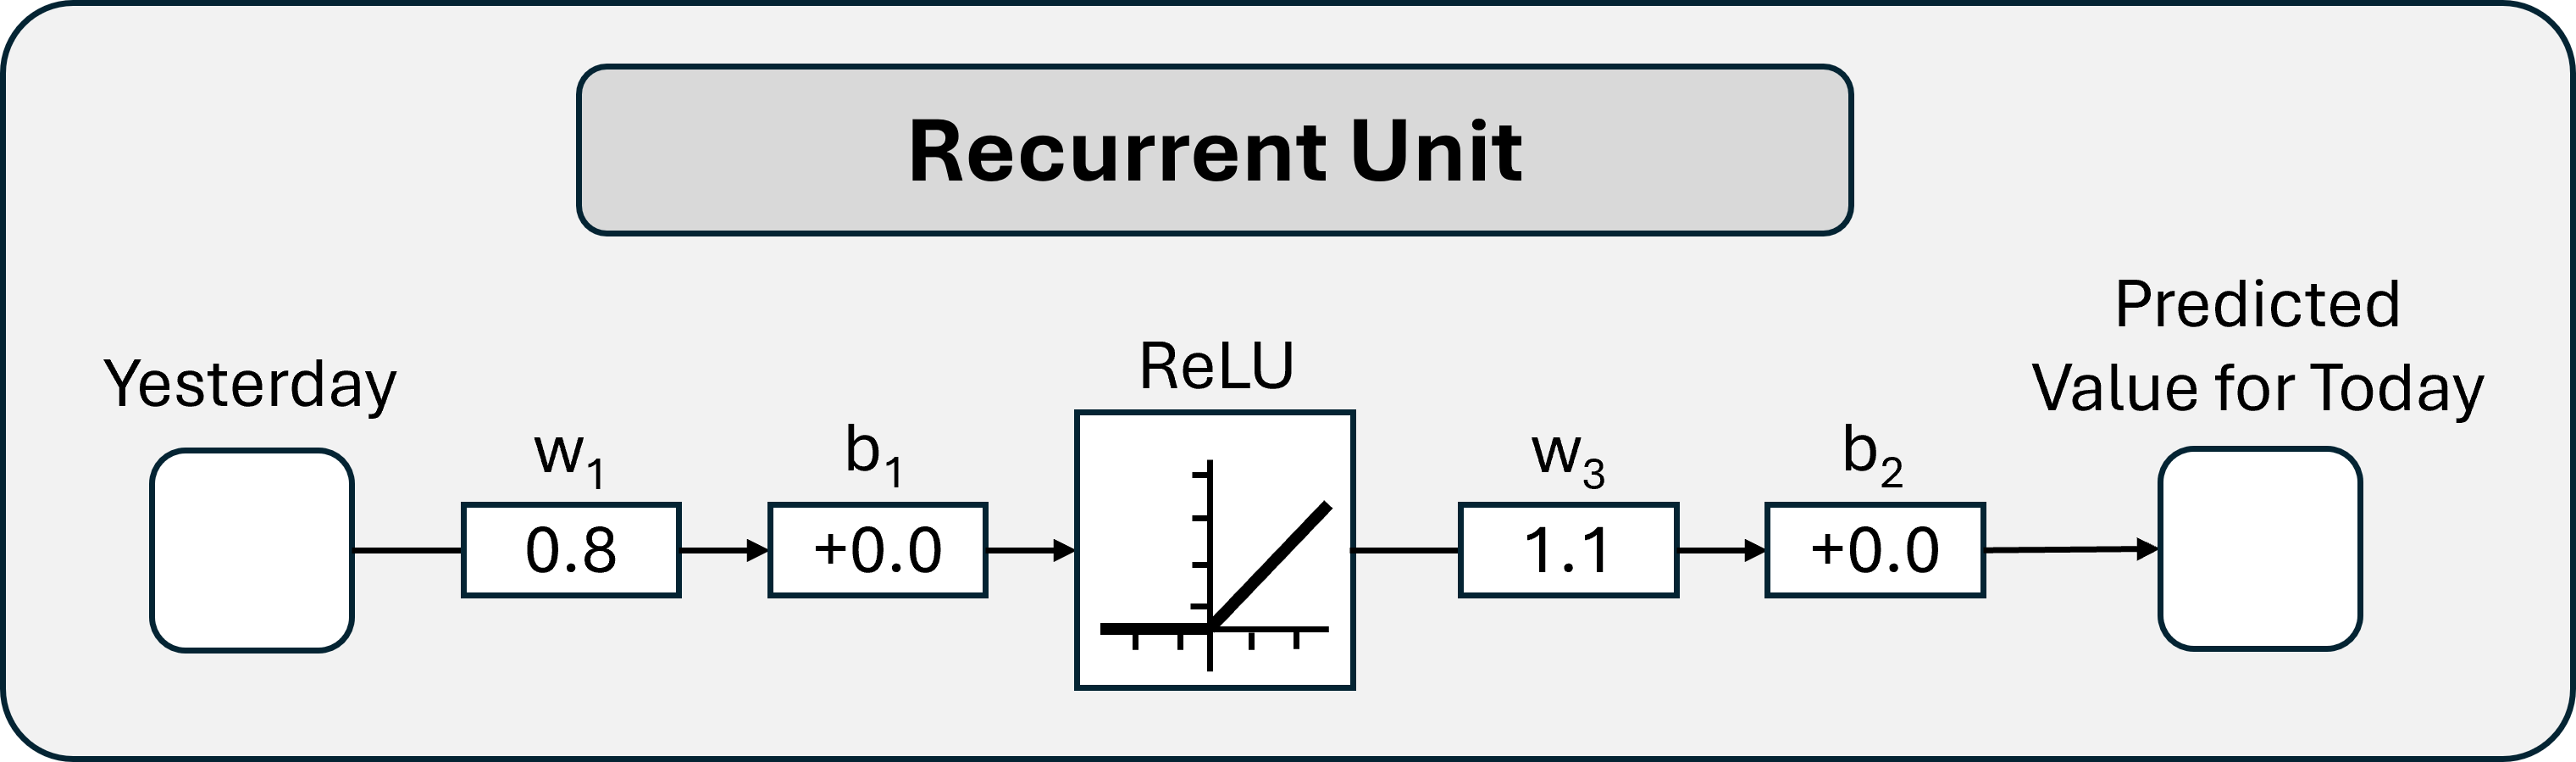

In [8]:
Image(filename='images/rnn_recurrent_unit.png', width=1000) 

This recurrent unit predicts the value for today, given the input of yesterday. It consists of three main components:

1. A weight and bias applied to the input
2. An activation function (in this case the ReLU function)
3. A weight and bias applied to the result of the activation function

What makes the recurrent unit special is that we can combine multiple recurrent units together, one for each time point:

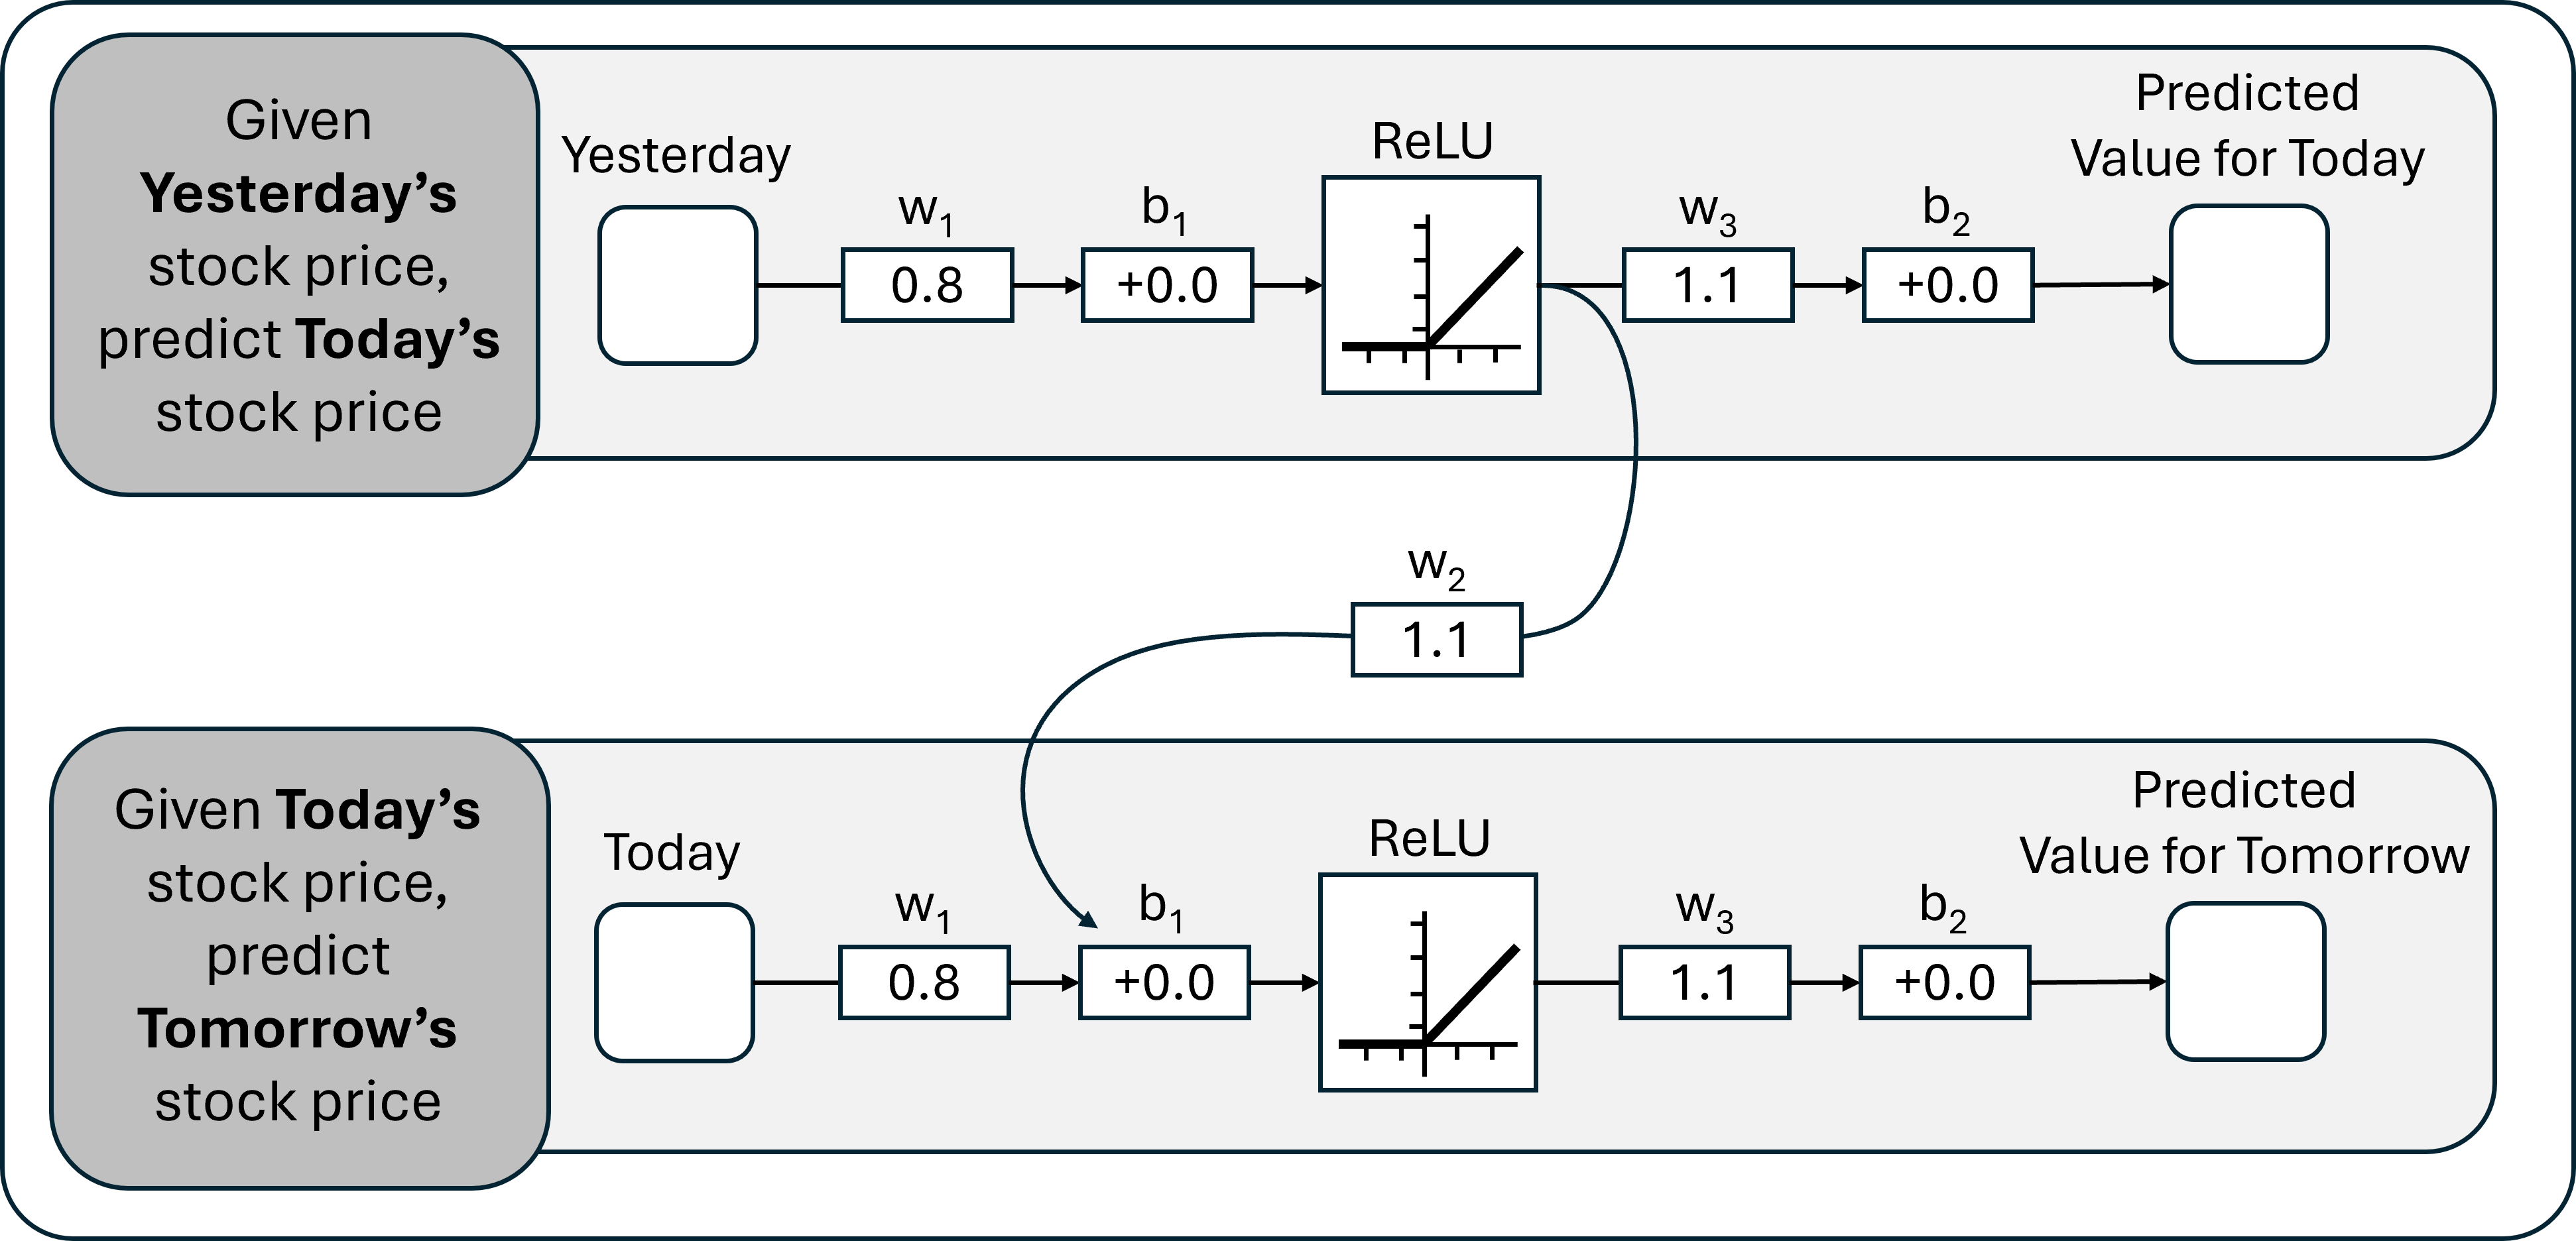

In [9]:
Image(filename='images/rnn_multiple_recurrent_units.png', width=1000) 

The network also passes information from one time point to the next. It accomplishes this by passing the **result from the activation function** ($y_{1}$) of the previous time point, also called the recursive unit's **hidden state**, multiplied by a **weight** ($w_{3}$ in this case) to the next time point. This is **added** to the result of $(\text{input} \times w_{1})$, then the bias is added to that result. The equation passed to the activation function of the next time point's recursive unit then looks like:

$(y_{1} \times w_{2}) + (\text{input} \times w_{1}) + b_{1}$
 
This means that the input to the activation function of the **current** recursive unit is influenced by the output of the activation function of the **previous** recursive unit, and the activation function of the previous recursive unit is influenced by the prediction for the unit before it, and so on back until the first time point. In this way, information about previous states is retained throughout the entire network.

Let's set up the logic for a recurrent unit:

In [12]:
def recurrent_unit(input, previous_hidden_state=0, verbose=False, apply_sigmoid=False):
    weight_1 = 1.8
    weight_2 = -0.5
    weight_3 = 1.1
    
    bias_1 = 0.0
    bias_2 = 0.0
    
    def calculate_activation_function_input(previous_hidden_state):
        """Calculates the first part of the equation"""
        if verbose:
            print(f"  Input for Activation Function \n\t= (input * weight_1) + (previous_hidden_state * weight_2) + bias_1 \n\t= ({input} * {weight_1}) + ({previous_hidden_state} * {weight_2}) + {bias_1} \n\t= {(input * weight_1) + (previous_hidden_state * weight_2) + bias_1}")
        return (input * weight_1) + (previous_hidden_state * weight_2) + bias_1
        
    def relu(input):
        if verbose:
            print(f"  Current hidden state \n\t= max(0, {input}) \n\t= {max(0, input)}")
        return max(0, input)
    
    def calculate_hidden_state(current_hidden_state):
        """Calculates the prediction for the next day based on the hidden state"""
        if verbose:
            print(f"  Prediction \n\t= (current_hidden_state * weight_3) + bias_2 \n\t= ({current_hidden_state} * {weight_3}) + {bias_2} \n\t= {round((current_hidden_state * weight_3) + bias_2,1)}")
        return (current_hidden_state * weight_3) + bias_2
    
    def sigmoid_function(val):
        if verbose:
            print(f"  Sigmoid function \n\t= 1 / (1 + e**-{val}) \n\t= {1 / (1 + math.e**-val)}")
        return 1 / (1 + math.e**-val)
    
    
    activation_function_input = calculate_activation_function_input(previous_hidden_state)
    
    current_hidden_state = relu(activation_function_input)
    
    current_prediction = calculate_hidden_state(current_hidden_state)
    
    if apply_sigmoid:
        current_prediction = sigmoid_function(current_prediction)
    
    return current_hidden_state, current_prediction, activation_function_input

This recurrent unit takes in an **input** and a **possible previous hidden state** (there is no previous hidden state if it's the first unit) and returns it's **hidden state** and it's **prediction** about the next time point. 

Now, let's create a chain of recurrent units that will predict the stock price of a company, given the stock prices of yesterday and today. Since we are working with data from **two time points** (yesterday and today), we will create **two connected recurrent units**.

In [14]:
# First, we need to have stock prices for yesterday and today as input
yesterdays_stock_price = 0
todays_stock_price = 0.5

print("Yesterday's recurrent unit")
yesterdays_hidden_state, todays_prediction, _ = recurrent_unit(yesterdays_stock_price, verbose=True)

print("\nToday's recurrent unit")
todays_hidden_state, tomorrows_prediction, _ = recurrent_unit(todays_stock_price, yesterdays_hidden_state, verbose=True)

print(f"\nTomorrow's predicted stock price = {round(tomorrows_prediction, 0)}")

Yesterday's recurrent unit
  Input for Activation Function 
	= (input * weight_1) + (previous_hidden_state * weight_2) + bias_1 
	= (0 * 1.8) + (0 * -0.5) + 0.0 
	= 0.0
  Current hidden state 
	= max(0, 0.0) 
	= 0
  Prediction 
	= (current_hidden_state * weight_3) + bias_2 
	= (0 * 1.1) + 0.0 
	= 0.0

Today's recurrent unit
  Input for Activation Function 
	= (input * weight_1) + (previous_hidden_state * weight_2) + bias_1 
	= (0.5 * 1.8) + (0 * -0.5) + 0.0 
	= 0.9
  Current hidden state 
	= max(0, 0.9) 
	= 0.9
  Prediction 
	= (current_hidden_state * weight_3) + bias_2 
	= (0.9 * 1.1) + 0.0 
	= 1.0

Tomorrow's predicted stock price = 1.0


Looking at the predictions, it may be confusing that the recurrent unit from **yesterday** predicted a value of **0.0** for today when the value of **today** was really **0.5**. This is **fine**, as we ignore the predicitons for all but the last recurrent unit (**we know the value of today**, we just need the recurrent unit to **pass along the information from yesterday**)

Let's set up the recurrent neural network in a more formal way, returning just the last prediction:

In [15]:
def recurrent_neural_network(stock_price_series, apply_sigmoid=False):
    unit_parameters = {
        "predictions": [],
        "activation_inputs": [],
        "hidden_states": []
    }
    
    hidden_state = 0
    prediction = 0
    
    # Iterate through the stock price series, using the recurrent unit with the last hidden state
    
    for i, price in enumerate(stock_price_series):
        
        # Apply the sigmoid function to the output of the last prediction
        if i+1 == len(stock_price_series):
            apply_sigmoid=True
            
        current_hidden_state, current_prediction, activation_function_input = recurrent_unit(price, hidden_state, apply_sigmoid=apply_sigmoid)
        
        # Update the hidden state and latest prediction
        hidden_state = current_hidden_state
        prediction = current_prediction
        
        # Keep track of each prediction, we can use it for calculating error later
        unit_parameters["predictions"].append(current_prediction)
        unit_parameters["activation_inputs"].append(activation_function_input)
        unit_parameters["hidden_states"].append(current_hidden_state)
        
    return prediction, unit_parameters

Now, we can use the randomized stock price generator and the stock market figure code to test out the predictions. We can change the number of random observations and the RNN will still work!

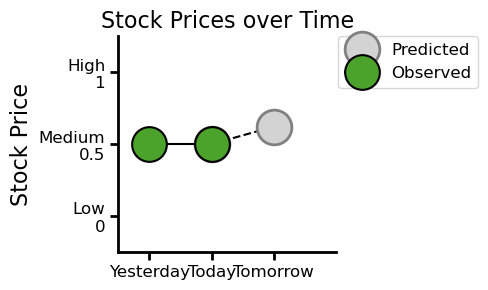

In [16]:
stock_prices = generate_random_observations(2)
# stock_prices = [1, 1]
predicted_stock_price, _ = recurrent_neural_network(stock_prices)

stock_market_figure(stock_prices, predicted_stock_price)

## Backpropagation Through Time
In order to calculate the effect each layer has on the loss, we need to take into account the error from each layer in the RNN. To do this, we use a concept called **Backpropagation Through Time (BTT)**. First, we need to set up an **objective function** that calculates the loss at each layer. Then to get the overall loss, we sum up the loss at each layer and take an average across all time points.

We will also want to add a sigmoid function to the predictions to clamp them between 0-1.

**Loss Function - Mean Squared Forecast Error (MSFE)**

$$L = \frac{1}{T}\sum^{T}_{t=1}(y_{t}-o_{t})^{2}$$

Where $y_{t}$ is the prediction at the current time step and $o_{t}$ is the expected output.

In [17]:
def calculate_msfe_loss(predictions, observations):
    mse_over_time = [(y-o)**2 for y, o in zip(predictions, observations)]
    loss = (1/len(observations)) * sum(mse_over_time)
    return loss, mse_over_time

Next, we will create a function to create a list of values for what we expect the model to predict. It takes a list of the stock prices at each time point, then uses the `expected_logic` function to determine what the last predicted value should be.

In [18]:
def create_expected_prediction_list(stock_price_observations):
    expected = [i for i in stock_price_observations[1:]]
    expected_last_price = expected_logic(stock_price_observations)
    expected.append(expected_last_price)
    return expected

Let's see how the predicted values differ from the observed and expected values

Stock prices: [0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5]
Expected: [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Predicted: [0.7, 0.5, 0.5, 0.5, 0.5, 0.7, 0.6, 0.7, 0.6, 0.7]
Final prediction: 0.6638781766503263


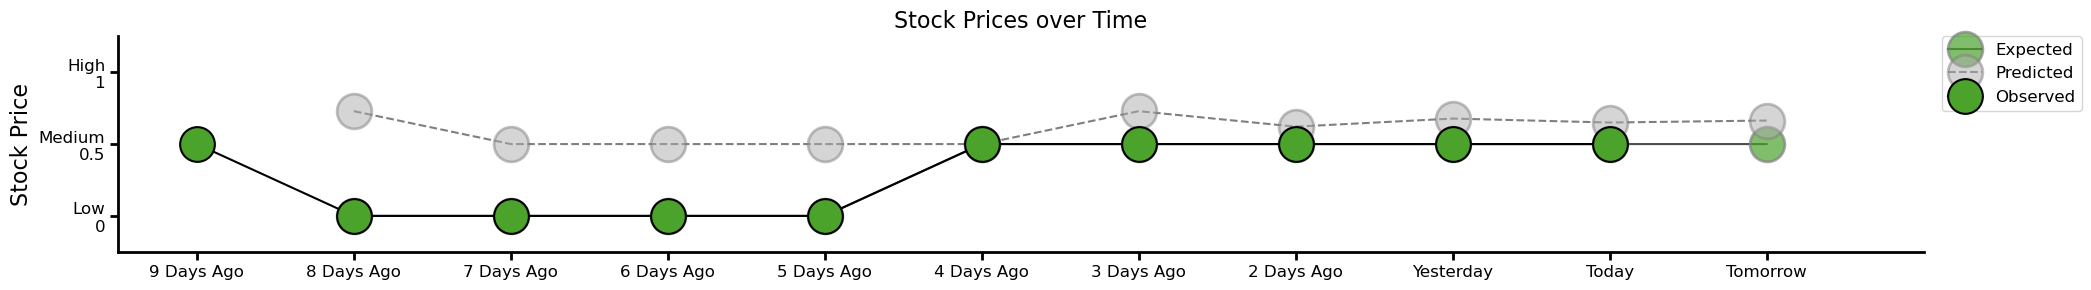

In [19]:
stock_prices = generate_random_observations(10)
predicted_stock_price, unit_parameters = recurrent_neural_network(stock_prices, apply_sigmoid=True)
expected = create_expected_prediction_list(stock_prices)

print(f"Stock prices: {stock_prices}")
print(f"Expected: {expected}")
print(f"Predicted: {[round(i,1) for i in unit_parameters['predictions']]}")
print(f"Final prediction: {predicted_stock_price}")
stock_market_figure(stock_prices, predictions=unit_parameters['predictions'], expected=expected)

Now, we can calculate the MSFE error by taking the average of the mean squared error (MSE) at each time point

In [20]:
loss, mse_over_time = calculate_msfe_loss(unit_parameters['predictions'], expected)

print(f"MSFE Error: {loss}")

print(f"Loss at each time point: {[round(i,3) for i in mse_over_time]}")

MSFE Error: 0.1429617773556245
Loss at each time point: [0.532, 0.25, 0.25, 0.25, 0.0, 0.052, 0.015, 0.032, 0.022, 0.027]


## Calculating the Gradients

Now that we have both the loss at each step and the overall loss, we can calcualte the **gradients**. The **gradient** is a calculation of the degree to which the loss is affected by each weight and bias in the model. The change in the loss due to a change in each parameter can be determined by using **differential equations** linked via the **chain rule** to trace back how the parameters affect each other. For example, we start by figuring out how the loss changes due to a change in the MSE error calculation:

The loss function is $L = \frac{1}{2}(y_{t} - \hat{y}_{t})^{2}$ where $L$ is the **loss**, $y_{t}$ is the **prediction** for the time point $t$, and $\hat{y}_{t}$ is the **expected value** for time point $t$.

---

### The change in loss with respect to the prediction:
$$\frac{\partial L}{\partial y_{t}} = (y_{t} - \hat{y}_{t})$$

> The derivative of the MSE loss function $\frac{1}{2}(prediction - observation)^{2}$ with respect to the prediction is $(prediction - observation)$.

Now that we know how much the loss changes due to the effect of the MSE equation, we need to know how much the loss changes with respect to changes in the prediction calculation.

The prediction calculation is $prediction = w_{3} \times \text{hidden state} + b_{2}$. We can use the **chain rule** to calculate how much the loss function changes with respect to $w_{3}$ and $b_{2}$:

---

### Change in loss due to a change in $w_{3}$:

$$\frac{\partial L}{\partial w_{3}} = \frac{\partial L}{\partial y_{t}} \times \frac{\partial y_{t}}{\partial w_{3}} = (y_{t} - \hat{y}_{t}) \times h_{t}$$

Where $h_{t}$ is the value of the **hidden state** at time point $t$.

In other words, the change in the loss due to $w_{3}$ is proportional to the change in loss due to a change in the prediction ***times*** the change in the prediction due to the value of the hidden state.

---

### Change in loss due to a change in $b_{2}$:

$$\frac{\partial L}{\partial b_{2}} = \frac{\partial L}{\partial y_{t}} \times \frac{\partial y_{t}}{\partial b_{2}} = (y_{t} - \hat{y}_{t}) \times 1 = (y_{t} - \hat{y}_{t})$$

The derivative of a variable added directly (like bias) is always 1 because its change *directly* affects the output by the same amount.

---

### Change in loss due to a change in the ReLU activation function $a_{t}$:

The change in $y_{t}$ due to $h_{t}$ is due to changes in $w_{3}$. The equation for $y_{t}$ is $y_{t} = w_{3} \times h_{t} + b_{2}$. The change in $h_{t}$ is directly proportional to a change in $w_{3}$, so the derivative of $w_{3} \times h_{t}$ with respect to $h_{t}$ is just $w_{3}$. The derivative of $b_{2}$ with respect to $h_{t}$ is 0, because the value of $h_{t}$ is not affected by changes to $b_{2}$. Therefore, 

$$\frac{\partial y_{t}}{\partial h_{t}} = w_{3}$$

So the change in loss due to a change in the activation function can be represented as:

$$\frac{\partial L}{\partial a_{t}} = \frac{\partial L}{\partial y_{t}} \times \frac{\partial L}{\partial h_{t}} \times \frac{\partial h_{t}}{\partial a_{t}} = (y_{t} - \hat{y}_{t}) \times w_{3} \times \text{ReLU}'{a_{t}}$$

The change in loss due to a change in the value of the activation inputs is due changes to $(prediction - observation)$, the value of w_{3}, and the output from the ReLU function.

---

### Change in loss due to the change in the pre-activation value passed to ReLU activation function $a_{t}$

The variables which affect the value of $a_{t}$ are:
1. $w_{1}$
2. $w_{2}$
3. $b_{1}$

The equation for $a_{t}$ is:

$$a_{t} = (x_{t} \times w_{1}) + (h_{t-1} \times w_{2}) + b_{1}$$

Where $x_{t}$ is the input value at time $t$ and $h_{t-1}$ is the output of the hidden function from the recurrent unit of the previous time point.

#### The change in the loss due to a change in $w_{1}$ is:

$$\frac{\partial L}{\partial w_{1}} = \frac{\partial L}{\partial a_{t}} \times \frac{\partial a_{t}}{\partial w_{1}} = \frac{\partial L}{\partial a_{t}} \times x_{t}$$

This is because the value of $w_{1}$ directly changes the result of $(x_{t} \times w_{1})$, and the value of $a_{t}$ is directly affected by the changes in the value of $(x_{t} \times w_{1})$.

#### The change in loss due to a change in $w_{2}$

$$\frac{\partial L}{\partial w_{2}} = \frac{\partial L}{\partial a_{t}} \times \frac{\partial a_{t}}{\partial w_{2}} = \frac{\partial L}{\partial a_{t}} \times h_{t-1}$$

This is because the value of $w_{2}$ directly changes the result of $(h_{t-1} \times w_{2})$, and the value of $a_{t}$ is directly affected by changes in the value of $(h_{t-1} \times w_{2})$.

### The change in loss due to a change in $b_{1}$

$$\frac{\partial L}{\partial b_{1}} = \frac{\partial L}{\partial a_{t}} \times \frac{\partial a_{t}}{\partial b_{1}} = \frac{\partial L}{\partial a_{t}} \times 1 = \frac{\partial L}{\partial a_{t}}$$

This is because the value of $b_{1}$ is added *directly*, a change in $b_{1}$ directly changes the value of $a_{t}$.

## Backpropagation Through Time (BPTT)

The above equations are used to calculate the gradients for a *single recurrent unit* at time point $t$. To get the total gradients for $w_{1}$, $w_{2}$, $w_{3}$, $b_{1}$, and $b_{2}$ across *all* recurrent units, we just calculate the gradients at each time point and sum the results.

In [21]:
print(f"Inputs: {stock_prices}")
print(f"Activation Inputs: {unit_parameters['activation_inputs']}")
print(f"Hidden States: {unit_parameters['hidden_states']}")
print(f"Predictions: {unit_parameters['predictions']}")
print(f"Expected: {expected}")
print(f"Loss per time step: {mse_over_time}")

Inputs: [0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5]
Activation Inputs: [0.9, -0.45, 0.0, 0.0, 0.0, 0.9, 0.45, 0.675, 0.5625, 0.61875]
Hidden States: [0.9, 0, 0, 0, 0, 0.9, 0.45, 0.675, 0.5625, 0.61875]
Predictions: [0.7290879223493065, 0.5, 0.5, 0.5, 0.5, 0.7290879223493065, 0.6212835951910678, 0.6775422953274693, 0.6499342022336527, 0.6638781766503263]
Expected: [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Loss per time step: [0.5315691985156284, 0.25, 0.25, 0.25, 0.0, 0.052481276166321894, 0.014709710462470804, 0.031521266630146344, 0.022480264999441873, 0.026856056782235564]


In [ ]:
def compute_gradients(inputs, activation_inputs, hidden_states, predictions, expected, w3):
    dw1 = []
    dw2 = []
    dw3 = []
    db1 = []
    db2 = []
    
    # Loop over each recurrent unit / time point
    for t in range(len(inputs)):
        x_t = inputs[t]
        a_t = activation_inputs[t]
        h_t = hidden_states[t]
        h_prev = hidden_states[t-1] if t > 0 else 0
        y_t = predictions[t]
        y_target = expected[t]
        
        # Change in loss with respect to the prediction - target
        dL_dy = y_t - y_target  # Derivative of 1/2(pred - obs)**2
        
        # Change in loss with respect to the inputs to the prediction
        dw3.append(dL_dy * h_t)      # Change in loss from w3 changes with the output of the activation function (current hidden state)
        db2.append(dL_dy)            # The loss changes directly based on b2, as this is added directly to the prediction
        
        # Chnge in loss with respect to the ReLU portion of the calculation
        relu_deriv = 1.0 if a_t > 0 else 0.0    # Derivative of ReLU
        dL_da = dL_dy * w3 * relu_deriv         # Change in loss from the activation funciton changes with w3 and the ReLU function
        
        # Sum the gradients for each recurrent unit
        dw1.append(dL_da * x_t)      # Change in loss from w1 changes with the activation function and input
        dw2.append(dL_da * h_prev)   # Change in loss from w2 changes with the activation function and previous hidden state
        db1.append(dL_da)            # Change in loss form b1 changes with the activation function
    
    return {
        "dw1": dw1,
        "dw2": dw2,
        "dw3": dw3,
        "db1": db1,
        "db2": db2
    }

gradient_dict = compute_gradients(stock_prices, unit_parameters["activation_inputs"], unit_parameters["hidden_states"], unit_parameters["predictions"], expected, w3=1.1)
print(f"Gradients at each time point:")
for key, value in gradient_dict.items():
    print(f"{key} = {value}")
    
print("\nTotal gradients")
for key, value in gradient_dict.items():
    print(f"{key} = {sum(value)}")

Gradients at each time point:
dw1 = [0.40099835729211863, 0.0, 0.0, 0.0, 0.0, 0.1259983572921186, 0.06670597735508729, 0.09764826243010814, 0.082463811228509, 0.09013299715767949]
dw2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12007075923915712, 0.08788343618709733, 0.11132614515848716, 0.10139962180238943]
dw3 = [0.6561791301143759, 0.0, 0.0, 0.0, 0.0, 0.20617913011437589, 0.05457761783598051, 0.11984104934604181, 0.08433798875642966, 0.10139962180238943]
db1 = [0.8019967145842373, 0.0, 0.0, 0.0, 0.0, 0.2519967145842372, 0.13341195471017459, 0.1952965248602163, 0.164927622457018, 0.18026599431535897]
db2 = [0.7290879223493065, 0.5, 0.5, 0.5, 0.0, 0.22908792234930653, 0.1212835951910678, 0.17754229532746935, 0.14993420223365272, 0.16387817665032633]

Total gradients
dw1 = 0.8639477627556212
dw2 = 0.42067996238713107
dw3 = 1.2225145379695932
db1 = 1.7278955255112425
db2 = 3.0708141141011294


## Gradient Descent

**Learning rate** = 0.001